<a href="https://colab.research.google.com/github/LuigiPagani/POD-Galerkin-for-Parabolic-PDEs/blob/main/POD_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
     import dlroms.fespaces as fe
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     import dlroms.fespaces as fe

In [2]:
#@title Seed Definition
import torch
import numpy as np
import random
import os

def set_seed(seed: int = 42):
    """
    Set seed for reproducibility.

    Args:
        seed (int): Seed to use for random number generators. Default is 42.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



# **Data-driven ROMs: the POD-NN approach**

When the PDE at hand involves nonlinear operators, implementing a POD-Galerkin ROM becomes highly nontrivial. In fact, suitable tricks, such as hyper-reduction, become necessary in order to ensure that the resulting ROM is sufficently fast (both in assembling the reduced system and in solving it). To overcome this difficulty, another approach is to switch from intrusive to nonintrusive methods, ultimately moving from physics-based ROMs towards data-driven ROMs.
</br>
</br>
We mentioned that methods based on POD rely on the following approximation

$$\mathbf{u}_{\boldsymbol{\mu}}\approx \mathbf{V}\mathbf{V}^\top\mathbf{u}_{\boldsymbol{\mu}},$$

where $\mathbf{V}\in\mathbb{R}^{N_h\times n}$ is the POD matrix. In particular, if we denote the POD coefficients by $\mathbf{c}_{\boldsymbol{\mu}}:=\mathbf{V}^\top\mathbf{u}_{\boldsymbol{\mu}}$, then the latter can be re-written as

$$\mathbf{u}_{\boldsymbol{\mu}}\approx \mathbf{V}\mathbf{c}_{\boldsymbol{\mu}}.$$

**In classical Reduced Basis methods**, such as POD-Galerkin, given $\boldsymbol{\mu}\in\mathbb{R}^{p}$, **the vector of POD coefficients is approximated by solving the projected PDE**, yielding $\tilde{\mathbf{c}}_{\boldsymbol{\mu}}\approx \mathbf{c}_{\boldsymbol{\mu}}$. For simple second order elliptic PDEs, this approximation is known to be optimal up to a constant (cf. Céa's Lemma).
</br>
</br>
**In contrast**, the idea behind data-driven techniques is to approximate the map
$$\mathbb{R}^{p}\ni\boldsymbol{\mu}\mapsto \mathbf{c}_{\boldsymbol{\mu}}\in\mathbb{R}^{n}$$
by fitting a suitable (nonlinear) regression model. To this end, a popular approach is to rely on deep neural networks: the resulting technique is typically referred to as **POD-NN**. The algorithm can be synthesized as follows:

- Collect FOM snapshots $\{\boldsymbol{\mu}_i, \mathbf{u}_{i}\}_{i=1}^{N}$, where $\mathbf{u}_i:=\mathbf{u}_{\boldsymbol{\mu}_i}$;

- Compute the POD basis $\mathbf{V}$ via SVD of the snapshots matrix

- Construct a new dataset $\{\boldsymbol{\mu}_i, \mathbf{c}_{i}\}_{i=1}^{N}$, consisting of parameter instances and POD coefficients, via projection $\mathbf{c}_{i}:=\mathbf{V}^\top\mathbf{u}_i$;

- Fit a neural network $\phi:\mathbb{R}^{p}\to\mathbb{R}^{n}$ so that $\phi(\boldsymbol{\mu}_i)\approx\mathbf{c}_{i}$;

- Define the ROM as the map $\boldsymbol{\mu}\mapsto \mathbf{V}\phi(\boldsymbol{\mu})$.

In [3]:
#@title FEM Solver definition
import numpy as np
import matplotlib.pyplot as plt


from fenics import*
import dlroms.fespaces as fe
import numpy as np
from IPython.display import clear_output as clc

mesh = fe.unitsquaremesh(80, 80)
Vh = fe.space(mesh, 'CG', 1)
xb = fe.coordinates(Vh)
clc()

def solveStokes(hpipe):
    domain = fe.rectangle((0, 0), (1, 1)) - fe.rectangle((0, hpipe), (1-hpipe, 1-hpipe))
    mesh = fe.mesh(domain, stepsize = 0.009)

    pP1  = FiniteElement("CG", mesh.ufl_cell(), 1)
    vP1B = VectorElement("CG",  mesh.ufl_cell(), 2)

    pspace, vspace = pP1, vP1B
    W = FunctionSpace(mesh, vspace * pspace)
    (b, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    space = fe.space(mesh, "CG", 2, scalar = False)

    a = 100*inner(grad(b), grad(v))*dx - div(v)*p*dx - q*div(b)*dx
    L = inner(Constant((0.0, 0.0)), v)*dx
    dbc = DirichletBC(W.sub(0), Constant((0.0, 0.0)), lambda x, on: on and x[0]>1e-12)
    dbc_in = DirichletBC(W.sub(0), Expression(("x[1]*(%.2f-x[1])/pow(%.2f, 3)" % (hpipe, hpipe), "0.0"), degree = 2),
                         lambda x, on: on and (x[0]<=1e-12) and (x[1]<0.5))
    dbc_out = DirichletBC(W.sub(1), Constant(0.0), lambda x, on: on and (x[0]<1e-12) and (x[1]>0.5))

    bp = Function(W)
    solve(a == L, bp, [dbc, dbc_out, dbc_in])
    clc()
    return bp


def FOMstep(u0, t, dt, bfield, sigma, hpipe):
    u, v  = TrialFunction(Vh), TestFunction(Vh)
    u0f = fe.asvector(u0, Vh)
    a = dt*(inner(sigma*grad(u), grad(v))*dx + 10*inner(bfield, grad(u))*v*dx) + u*v*dx
    f = u0f*v*dx

    dbc = DirichletBC(Vh, Constant(1.0-np.exp(-t)), lambda x, on: on and x[0]<=1e-12 and x[1]<=hpipe)

    u = Function(Vh)
    solve(a == f, u, dbc)
    return u.vector()[:]


def FOMsolver(hpipe, dpipe, dbulk):
    bp = solveStokes(hpipe)
    b = []
    for x in xb:
        try:
            b.append(list(bp(*x))[:2])
        except:
            b.append([0.0, 0.0])
    b = np.stack(b).reshape(-1)
    Vb = fe.space(Vh.mesh(), 'CG', 1, scalar = False)
    bfield = fe.asvector(b, Vb)

    x, y = fe.coordinates(Vh).T
    ind = (x>(1.0-hpipe)) + (x<=(1.0-hpipe))*(np.abs(y-0.5)>(0.5-hpipe))
    sigma = dpipe*ind + (1-ind)*dbulk
    sigma = fe.asvector(sigma, Vh)

    u = [np.zeros(Vh.dim())]
    t = 0.0
    dt = 5e-2
    for j in range(100):
        u.append(FOMstep(u[-1], t, dt, bfield, sigma, hpipe))
        t += dt
    return 1.0 - np.stack(u)





In [ ]:
#@title Example of Dataset Generation
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

# Define the parameter ranges
delta_range = (0.05, 0.1)
D_range = (1, 5)
d_range = (0.02, 0.08)

num_samples = 1
params = np.zeros((num_samples, 3))
params[:, 0] = np.random.uniform(delta_range[0], delta_range[1], num_samples)  # deltas
params[:, 1] = np.random.uniform(D_range[0], D_range[1], num_samples)          # Ds
params[:, 2] = np.random.uniform(d_range[0], d_range[1], num_samples)          # ds

snapshots = None

# Iterate over all combinations of parameters in the generated array
for p in params:
    delta, D, d = p
    u = FOMsolver(delta, D, d)

    if snapshots is None:
        snapshots = u  # Initialize with the first result
    else:
        snapshots = np.vstack((snapshots, u))  # Stack horizontally with the existing snapshots



In [6]:
#@title Saving Snapshots
snapshots = np.array(snapshots)
np.save('snapshots.npy', snapshots)
np.save('params.npy', params)

In [13]:
#@title Download Snapshots
import gdown
gdown.download(id = "1ZuOj-2t9jkP-JCmIskgFO1vjnUJAG0pC", output = "snapshots.npy", quiet=False)
gdown.download(id = "1TS4UTBRS_A3KZf760j92xxJYeDf8nQ43", output = "params.npy", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1ZuOj-2t9jkP-JCmIskgFO1vjnUJAG0pC
From (redirected): https://drive.google.com/uc?id=1ZuOj-2t9jkP-JCmIskgFO1vjnUJAG0pC&confirm=t&uuid=8cbce418-219e-41ae-b3a8-af09abaae8ec
To: /content/snapshots.npy
100%|██████████| 265M/265M [00:02<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TS4UTBRS_A3KZf760j92xxJYeDf8nQ43
To: /content/params.npy
100%|██████████| 1.33k/1.33k [00:00<00:00, 3.72MB/s]


'params.npy'

In [14]:
#@title Loading Snapshots
snapshots = np.load('/content/snapshots.npy')
params = np.load('/content/params.npy')


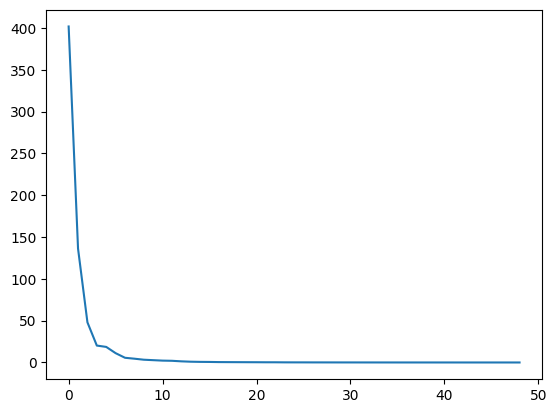

In [15]:
u = snapshots
ntimes = 101
ntrain_traj = 40
ntrain_snaps = ntrain_traj*ntimes
from scipy.linalg import svd
X, s, Yt = svd(u[:ntrain_snaps].T, full_matrices = False)
plt.plot(s[1:50])
plt.show()

The rapid decay of singular values suggests that a small number of basis functions can accurately represent the system. Therefore, we choose the POD-NN architecture, instead of the DL-ROM one.


In [16]:
#@title Neural Network Training

n = 5
V = X[:, :n]
snapshots1 = snapshots

from dlroms import*
mu = dv.tensor(params)

ndata, nh = 50,6561
p = 3

print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)


mut = dv.zeros(ndata, ntimes, p+1)
times = dv.tensor(np.linspace(0, 5, ntimes))

for i in range(ndata):
    mut[i,:,:3] = mu[i]
    mut[i,:, 3] = times

mut = mut.reshape(-1, p+1)
u = dv.tensor(u)
V = dv.tensor(V)
c = u @ V
c.shape
phi = Dense(mut.shape[1], 100) + Dense(100, 500) +  Dense(500, n, activation = None)
model = DFNN(phi)
model.He()
model.moveOn(dv)
set_seed(13)
model.train(mut, c, ntrain = ntrain_snaps, epochs = 1500, loss = mse(euclidean))

model.freeze()
model.eval()

uROM = model(mut[ntrain_snaps:]) @ V.T
print("Average relative error of POD-NN: %s." % num2p(mre(euclidean)(u[ntrain_snaps:], uROM)))





		Train		Test
Epoch 2000:	1.02e-02	4.51e-01.

>> ETA: 0.30s.

Training complete. Elapsed time: 10 minutes 7.41 seconds.
Average relative error of POD-NN: 2.20%.


# **Error Study for Validation Set**

(10, 101, 1)


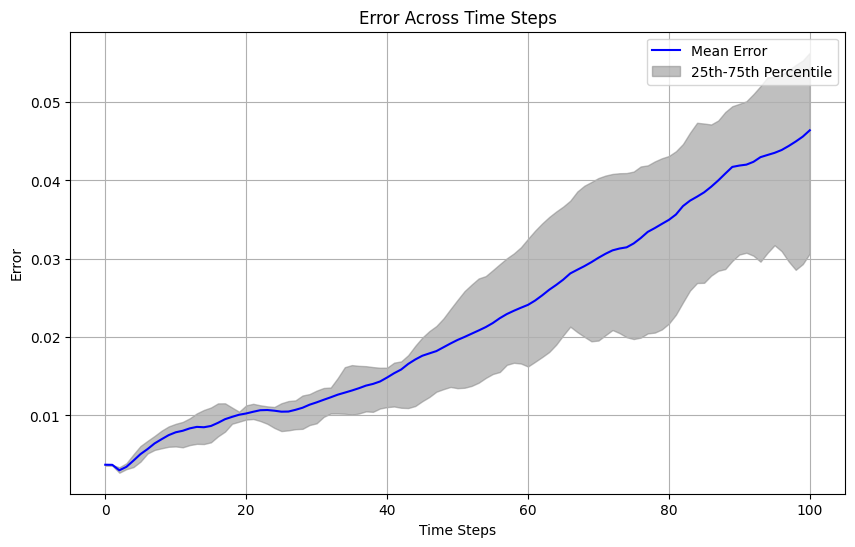

In [27]:
import numpy as np
import torch
error = u[ntrain_snaps:] - uROM
error = error.reshape(ndata - ntrain_traj, ntimes, 6561)

# Convert error to numpy on CPU
error_cpu = error.cpu().numpy()

u_cpu = u.cpu().numpy()
u_cpu = u_cpu.reshape(ndata, ntimes, nh)

error_norms = np.linalg.norm(error_cpu, axis=2, keepdims=True)
u_norms = np.linalg.norm(u_cpu[ ntrain_traj:], axis=2, keepdims=True)

relative_error_matrix = error_norms / u_norms

print(relative_error_matrix.shape)

import numpy as np
import matplotlib.pyplot as plt


relative_error_matrix = np.squeeze(relative_error_matrix)

# Preallocate arrays for statistics
means = np.zeros(ntimes)
quantile_25 = np.zeros(ntimes)
quantile_75 = np.zeros(ntimes)

# Calculate statistics for each time step
for i in range(ntimes):
    means[i] = np.mean(relative_error_matrix[:, i])
    quantile_25[i] = np.percentile(relative_error_matrix[:, i], 25)
    quantile_75[i] = np.percentile(relative_error_matrix[:, i], 75)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(means, label='Mean Error', color='blue')
plt.fill_between(range(ntimes), quantile_25, quantile_75, color='gray', alpha=0.5, label='25th-75th Percentile')
plt.title('Error Across Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()



# **Visualization**


In [28]:
uROM.shape
uROM = uROM.reshape(ndata-ntrain_traj, ntimes, 6561)

**Animation of a FOM solution**

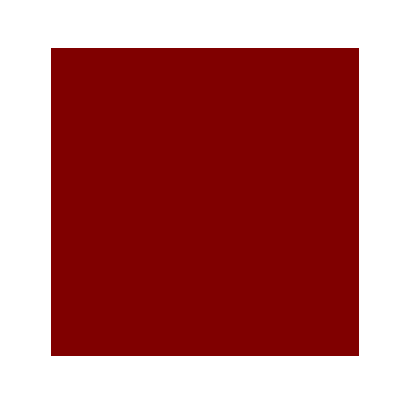

In [31]:
fe.animate(u_cpu[46],Vh)

**Animation of the corresponding ROM reconstruction**

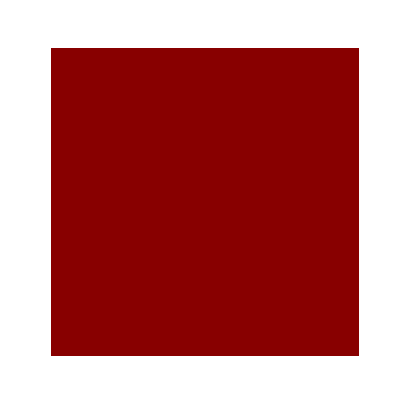

In [29]:
fe.animate(uROM[6],Vh)

**FOM solution Snapshots**

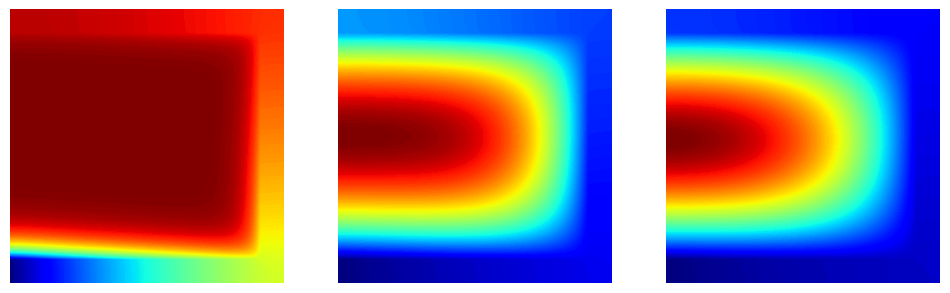

In [47]:
fe.multiplot(u_cpu[45][[5,50,100]],(1,3),Vh)

**ROM solution Snapshots**

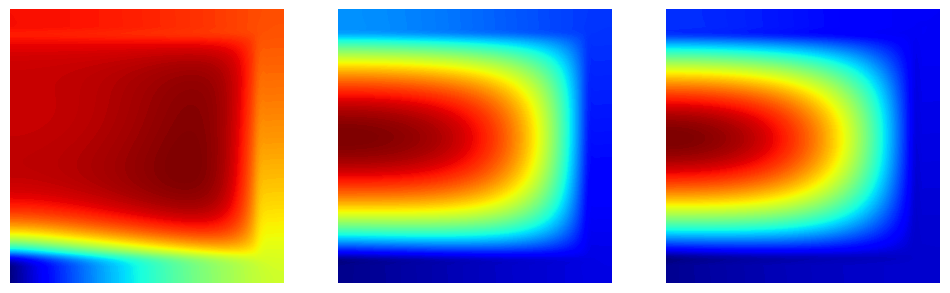

In [42]:
fe.multiplot(uROM[5][[5,50,100]],(1,3),Vh)


# **Computational Cost Comparison & Out of Distribution Generalization for parameters**

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import time


# Define the parameter ranges
delta_range = (0.1, 0.15)
D_range = (5, 10)
d_range = (0.08, 0.14)

# Generate an 8x3 array of random parameter values within the specified ranges
num_samples = 10
params = np.zeros((num_samples, 3))
params[:, 0] = np.random.uniform(delta_range[0], delta_range[1], num_samples)  # deltas
params[:, 1] = np.random.uniform(D_range[0], D_range[1], num_samples)          # Ds
params[:, 2] = np.random.uniform(d_range[0], d_range[1], num_samples)          # ds

# Initialize snapshots as None
snapshots = None

# Initialize a list to store the time taken for each solution
times = []

# Iterate over all combinations of parameters in the generated array
for p in params:
    delta, D, d = p
    # Measure the time before solving the model
    start_time = time.time()

    # Solve the model for the current set of parameters
    u = FOMsolver(delta, D, d)

    # Measure the time after solving the model
    end_time = time.time()

    # Calculate the time taken and append to the list
    times.append(end_time - start_time)

    # Assemble the snapshot matrix
    if snapshots is None:
        snapshots = u  # Initialize with the first result
    else:
        snapshots = np.vstack((snapshots, u))  # Stack horizontally with the existing snapshots

# Calculate the average time
average_time = np.mean(times)
print(f"Average time to produce the 10 solutions for each solution: {average_time:.4f} seconds")


Average time to produce the 10 solutions for each solution: 11.7608 seconds


In [59]:
import numpy as np
import time


mu = dv.tensor(params)
mut = dv.zeros(10, 101, 4)
times = dv.tensor(np.linspace(0, 5, ntimes))

for i in range(10):
    mut[i,:,:3] = mu[i]
    mut[i,:, 3] = times
mut = mut.reshape(-1, 4)

# Start timer
start_time = time.time()

# Call model
uROM = model(mut) @ V.T

# End timer and print time
end_time = time.time()
urom_avg_time = (end_time - start_time) / 10
print(f"Time taken: {urom_avg_time} seconds")

snapshots = snapshots.reshape(10, 101, 6561)
snapshots = snapshots.reshape(-1, 6561)
u_tensor = dv.tensor(snapshots)
snapshots = snapshots.reshape(10, 101, 6561)
snapshots = snapshots.reshape(-1, 6561)
u_tensor = dv.tensor(snapshots)

print("Average relative error of POD-NN: %s." % num2p(mre(euclidean)(u_tensor, uROM)))

speedup = average_time / urom_avg_time
print(f"Speedup: {speedup:.2e}")


Time taken: 6.854534149169922e-05 seconds
Average relative error of POD-NN: 66.63%.
Speedup: 1.72e+05


# **Out of distribution Generalization Performance for time**

In the following code cells, I have modified the FOM solver to generate simulations for an extended time period of 200 time steps, doubling the original timespan. I then calculate the average error across all simulations and all time steps. Additionally, I plot the average error across time steps. The resulting graph demonstrates an explosion of error for out-of-distribution time samples.


In [60]:
import numpy as np
import matplotlib.pyplot as plt


from fenics import*
import dlroms.fespaces as fe
import numpy as np
from IPython.display import clear_output as clc

ndata = 10
ntimes = 201


mesh = fe.unitsquaremesh(80, 80)
Vh = fe.space(mesh, 'CG', 1)
xb = fe.coordinates(Vh)
clc()

def solveStokes(hpipe):
    domain = fe.rectangle((0, 0), (1, 1)) - fe.rectangle((0, hpipe), (1-hpipe, 1-hpipe))
    mesh = fe.mesh(domain, stepsize = 0.009)

    pP1  = FiniteElement("CG", mesh.ufl_cell(), 1)
    vP1B = VectorElement("CG",  mesh.ufl_cell(), 2)

    pspace, vspace = pP1, vP1B
    W = FunctionSpace(mesh, vspace * pspace)
    (b, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    space = fe.space(mesh, "CG", 2, scalar = False)

    a = 100*inner(grad(b), grad(v))*dx - div(v)*p*dx - q*div(b)*dx
    L = inner(Constant((0.0, 0.0)), v)*dx
    dbc = DirichletBC(W.sub(0), Constant((0.0, 0.0)), lambda x, on: on and x[0]>1e-12)
    dbc_in = DirichletBC(W.sub(0), Expression(("x[1]*(%.2f-x[1])/pow(%.2f, 3)" % (hpipe, hpipe), "0.0"), degree = 2),
                         lambda x, on: on and (x[0]<=1e-12) and (x[1]<0.5))
    dbc_out = DirichletBC(W.sub(1), Constant(0.0), lambda x, on: on and (x[0]<1e-12) and (x[1]>0.5))

    bp = Function(W)
    solve(a == L, bp, [dbc, dbc_out, dbc_in])
    clc()
    return bp


def FOMstep(u0, t, dt, bfield, sigma, hpipe):
    u, v  = TrialFunction(Vh), TestFunction(Vh)
    u0f = fe.asvector(u0, Vh)
    a = dt*(inner(sigma*grad(u), grad(v))*dx + 10*inner(bfield, grad(u))*v*dx) + u*v*dx
    f = u0f*v*dx

    dbc = DirichletBC(Vh, Constant(1.0-np.exp(-t)), lambda x, on: on and x[0]<=1e-12 and x[1]<=hpipe)

    u = Function(Vh)
    solve(a == f, u, dbc)
    return u.vector()[:]


def FOMsolver(hpipe, dpipe, dbulk):
    bp = solveStokes(hpipe)
    b = []
    for x in xb:
        try:
            b.append(list(bp(*x))[:2])
        except:
            b.append([0.0, 0.0])
    b = np.stack(b).reshape(-1)
    Vb = fe.space(Vh.mesh(), 'CG', 1, scalar = False)
    bfield = fe.asvector(b, Vb)

    x, y = fe.coordinates(Vh).T
    ind = (x>(1.0-hpipe)) + (x<=(1.0-hpipe))*(np.abs(y-0.5)>(0.5-hpipe))
    sigma = dpipe*ind + (1-ind)*dbulk
    sigma = fe.asvector(sigma, Vh)

    u = [np.zeros(Vh.dim())]
    t = 0.0
    dt = 5e-2
    for j in range(ntimes-1):
        u.append(FOMstep(u[-1], t, dt, bfield, sigma, hpipe))
        t += dt
    return 1.0 - np.stack(u)







In [61]:
import numpy as np
import matplotlib.pyplot as plt



# Set the seed for reproducibility
np.random.seed(42)

# Define the parameter ranges
delta_range = (0.05, 0.1)
D_range = (1, 5)
d_range = (0.02, 0.08)

# Generate an 8x3 array of random parameter values within the specified ranges
num_samples = 10
params = np.zeros((num_samples, 3))
params[:, 0] = np.random.uniform(delta_range[0], delta_range[1], num_samples)  # deltas
params[:, 1] = np.random.uniform(D_range[0], D_range[1], num_samples)          # Ds
params[:, 2] = np.random.uniform(d_range[0], d_range[1], num_samples)          # ds

# Initialize snapshots as None
snapshots2 = None

# Iterate over all combinations of parameters in the generated array
for p in params:
    delta, D, d = p
    # Solve the model for the current set of parameters
    u = FOMsolver(delta, D, d)

    # Assemble the snapshot matrix
    if snapshots2 is None:
        snapshots2 = u  # Initialize with the first result
    else:
        snapshots2 = np.vstack((snapshots2, u))  # Stack horizontally with the existing snapshots



In [62]:
mu = dv.tensor(params)
mut = dv.zeros(ndata, ntimes, 4)
times = dv.tensor(np.linspace(0, 10, ntimes))

for i in range(ndata):
    mut[i,:,:3] = mu[i]
    mut[i,:, 3] = times
mut = mut.reshape(-1, 4)
#start timer
start_time = time.time()
u = dv.tensor(snapshots2)

#call model
uROM = model(mut) @ V.T
#end timer and print time 10
end_time = time.time()
urom_avg_time = (end_time - start_time)/10
print(f"Time taken: {urom_avg_time} seconds")
print("Average relative error of POD-NN: %s." % num2p(mre(euclidean)(u, uROM)))
speedup = average_time/urom_avg_time
print(f"Speedup: {speedup:.2f}")






Time taken: 0.004135012626647949 seconds
Average relative error of POD-NN: 256.57%.
Speedup: 2844.20


In [63]:
import numpy as np
import torch


error = u - uROM
error = error.reshape(ndata, ntimes, 6561)

error_cpu = error.cpu().numpy()

u_cpu = u.cpu().numpy()
u_cpu = u_cpu.reshape(ndata, ntimes, nh)

error_norms = np.linalg.norm(error_cpu, axis=2, keepdims=True)
u_norms = np.linalg.norm(u_cpu, axis=2, keepdims=True)

relative_error_matrix = error_norms / u_norms




(10, 201, 1)


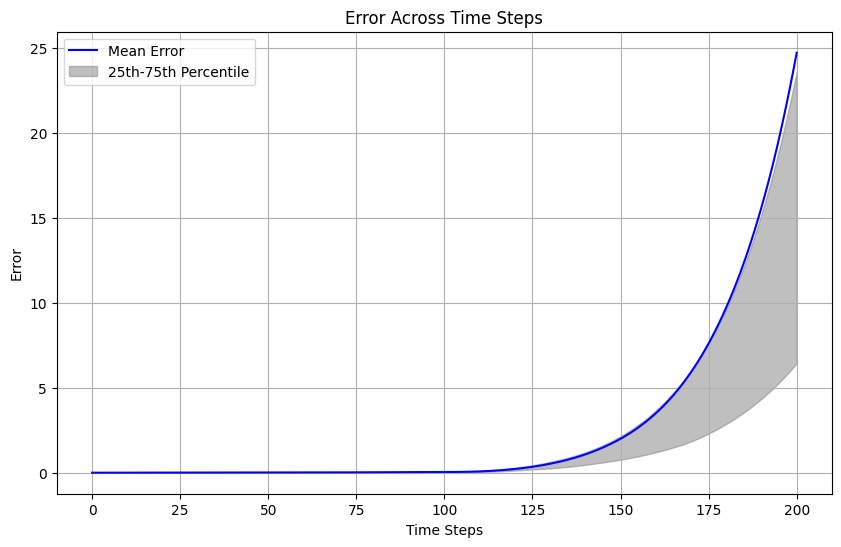

In [64]:
import numpy as np
import matplotlib.pyplot as plt

relative_error_matrix = np.squeeze(relative_error_matrix)

means = np.zeros(ntimes)
quantile_25 = np.zeros(ntimes)
quantile_75 = np.zeros(ntimes)

for i in range(ntimes):
    means[i] = np.mean(relative_error_matrix[:, i])
    quantile_25[i] = np.percentile(relative_error_matrix[:, i], 25)
    quantile_75[i] = np.percentile(relative_error_matrix[:, i], 75)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(means, label='Mean Error', color='blue')
plt.fill_between(range(ntimes), quantile_25, quantile_75, color='gray', alpha=0.5, label='25th-75th Percentile')
plt.title('Error Across Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


# **Paramter Optimization via ROM**

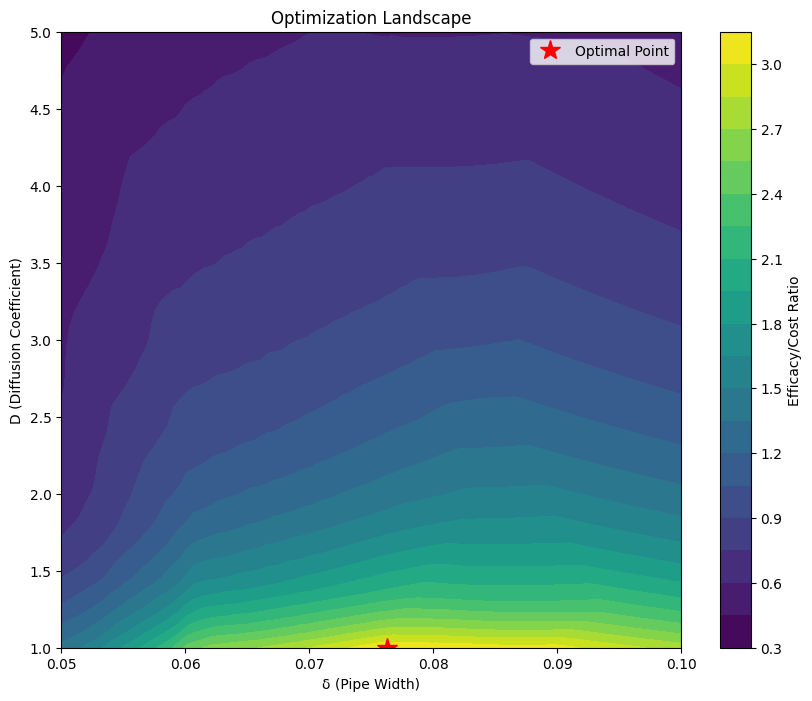

Optimal delta: 0.0763
Optimal D: 1.0000
Optimal Efficacy/Cost ratio: 3.1231
Optimal efficacy: 0.8800
Optimal cost: 0.2818


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from dlroms import *

def cost(delta, D):
    A_delta = 1 - (1 - 2*delta)**2
    return A_delta * D

def efficacy(delta, D, d, model, V):
    # Create input for the ROM
    mu = np.array([delta, D, d])
    t = np.linspace(0, 5, 101)
    mut = np.column_stack([np.tile(mu, (101, 1)), t])
    mut_tensor = dv.tensor(mut)
    u_rom = model(mut_tensor) @ V.T

    # Get the final time step
    u_final = u_rom[-1]

    # Calculate the proportion of bulk area where u < 0.2
    bulk_area = (1 - 2*delta)**2
    cool_area = (u_final < 0.2).sum().item() / u_final.shape[0] * bulk_area

    return cool_area / bulk_area

def objective(delta, D, d, model, V):
    eff = efficacy(delta, D, d, model, V)
    c = cost(delta, D)
    return eff / c

def grid_search_optimization(model, V):
    # Define the grid
    delta_range = np.linspace(0.05, 0.1, 100)
    D_range = np.linspace(1, 5, 100)
    d = 0.04  # Fixed as per the problem statement

    # Initialize arrays to store results
    results = np.zeros((len(delta_range), len(D_range)))

    # Perform grid search
    for i, delta in enumerate(delta_range):
        for j, D in enumerate(D_range):
            results[i, j] = objective(delta, D, d, model, V)

    # Find the optimal parameters
    i_opt, j_opt = np.unravel_index(np.argmax(results), results.shape)
    delta_star = delta_range[i_opt]
    D_star = D_range[j_opt]

    # Visualize the optimization landscape
    Delta, D = np.meshgrid(delta_range, D_range)
    plt.figure(figsize=(10, 8))
    plt.contourf(Delta, D, results.T, levels=20, cmap='viridis')
    plt.colorbar(label='Efficacy/Cost Ratio')
    plt.xlabel('δ (Pipe Width)')
    plt.ylabel('D (Diffusion Coefficient)')
    plt.title('Optimization Landscape')
    plt.plot(delta_star, D_star, 'r*', markersize=15, label='Optimal Point')
    plt.legend()
    plt.show()

    return delta_star, D_star, results[i_opt, j_opt]

# Run the optimization
delta_star, D_star, optimal_value = grid_search_optimization(model, V)

print(f"Optimal delta: {delta_star:.4f}")
print(f"Optimal D: {D_star:.4f}")
print(f"Optimal Efficacy/Cost ratio: {optimal_value:.4f}")

# Evaluate the optimal design
d = 0.04
optimal_efficacy = efficacy(delta_star, D_star, d, model, V)
optimal_cost = cost(delta_star, D_star)

print(f"Optimal efficacy: {optimal_efficacy:.4f}")
print(f"Optimal cost: {optimal_cost:.4f}")